In [28]:
# Importing necessary libraries

import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
# Read CSV input file 

df = pd.read_csv(".//Dataset//ctr.csv")

In [30]:
df

,Date,Clicks,Impressions
0,2022-10-19,2851,58598
1,2022-10-20,2707,57628
2,2022-10-21,2246,50135
3,2022-10-22,1686,40608
4,2022-10-23,1808,41999
...,...,...,...
360,2023-10-14,885,28487
361,2023-10-15,1180,33440
362,2023-10-16,1624,41688
363,2023-10-17,1751,40957


In [31]:
# DateTime conversion
df['Date']= pd.to_datetime(df['Date'],format= "%Y-%m-%d")

df.set_index('Date', inplace=True)


In [32]:
# Visualize the clicks and impressions over time

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df["Clicks"], mode="lines", name="Clicks"))
fig.add_trace(go.Scatter(x=df.index, y=df["Impressions"], mode="lines", name="Impressions"))
fig.update_layout(title='Clicks and Impressions Over Time')

In [33]:
# Relationship between clicks and impressions

# Create a scatter plot to visualize the relationship between Clicks and Impressions
fig = px.scatter(df, x='Clicks', y='Impressions', title='Relationship Between Clicks and Impressions',
                 labels={'Clicks': 'Clicks', 'Impressions': 'Impressions'})

# Customize the layout
fig.update_layout(xaxis_title='Clicks', yaxis_title='Impressions')

# Show the plot
fig.show()

In [34]:
# Calculate and visualize CTR
df['CTR'] = (df['Clicks'] / df['Impressions']) * 100
fig = px.line(df, x=df.index, y='CTR', title='Click-Through Rate (CTR) Over Time')
fig.show()

In [35]:
# Average CTR by day of the week:

df['DayOfWeek'] = df.index.dayofweek
df['WeekOfMonth'] = df.index.week // 4

# EDA based on DayOfWeek
day_of_week_ctr = df.groupby('DayOfWeek')['CTR'].mean().reset_index()
day_of_week_ctr['DayOfWeek'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig = px.bar(day_of_week_ctr, x='DayOfWeek', y='CTR', title='Average CTR by Day of the Week')
fig.show()

<ipython-input-35-69a23a82feb3>:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [36]:
# CTR on weekdays and weekends

# Create a new column 'DayCategory' to categorize weekdays and weekends
df['DayCategory'] = df['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average CTR for weekdays and weekends
ctr_by_day_category = df.groupby('DayCategory')['CTR'].mean().reset_index()

# Create a bar plot to compare CTR on weekdays vs. weekends
fig = px.bar(ctr_by_day_category, x='DayCategory', y='CTR', title='Comparison of CTR on Weekdays vs. Weekends',
             labels={'CTR': 'Average CTR'})

# Customize the layout
fig.update_layout(yaxis_title='Average CTR')

# Show the plot
fig.show()


In [37]:
# Impressions and clicks on weekdays and weekends comparision

# Group the data by 'DayCategory' and calculate the sum of Clicks and Impressions for each category
grouped_df = df.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

# Create a grouped bar chart to visualize Clicks and Impressions on weekdays vs. weekends
fig = px.bar(grouped_df, x='DayCategory', y=['Clicks', 'Impressions'],
             title='Impressions and Clicks on Weekdays vs. Weekends',
             labels={'value': 'Count', 'variable': 'Metric'},
             color_discrete_sequence=['blue', 'green'])

# Customize the layout
fig.update_layout(yaxis_title='Count')
fig.update_xaxes(title_text='Day Category')

# Show the plot
fig.show()

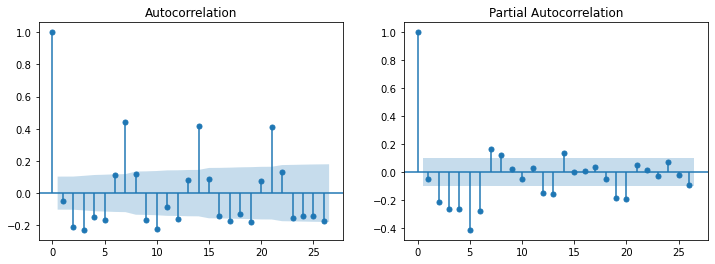

In [38]:
df.reset_index(inplace=True)

# resetting index
time_series = df.set_index('Date')['CTR']

# Differencing
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [39]:
# train the forecasting model using SARIMA

p, d, q, s = 1, 1, 1, 12

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))
results = model.fit()
print(results.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                      
Dep. Variable:                                CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -71.364
Date:                            Wed, 10 Apr 2024   AIC                            152.729
Time:                                    15:45:34   BIC                            172.047
Sample:                                10-19-2022   HQIC                           160.416
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5266      0.070      7.508      0.000       0.389       0.664
ma.L1         -0.9048      0.036   

In [40]:
# Predicting the future CTR values

future_steps = 100
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)

2023-10-19    3.852386
2023-10-20    3.889481
2023-10-21    3.820334
2023-10-22    3.727538
2023-10-23    3.710386
                ...   
2024-01-22    3.545527
2024-01-23    3.466600
2024-01-24    3.561147
2024-01-25    3.546659
2024-01-26    3.580067
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


In [42]:
# Visualize the forecasted trend of CTR

# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='CTR Forecasting',
                  xaxis_title='Time Period',
                  yaxis_title='Impressions',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()